# Many-to-one LSTM

ref: UCB-CS282-John F. Canny

In this notebook we implement Many-to-One Long Short-Term Memory using a modular approach. For each layer we implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
  
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive derivative of loss with respect to outputs and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.

In addition to implementing LSTM networks of arbitrary depth, we also explore different update rules for optimization, and introduce Dropout as a regularizer and Batch Normalization as a tool to more efficiently optimize deep networks.
  

In [4]:
# A bit of setup

import time
import numpy as np
import matplotlib.pyplot as plt
from batchnormlstm.classifiers.lstm import *
from batchnormlstm.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from batchnormlstm.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Load test dataset and process it.
import pandas as pd
raw = pd.read_csv('.\\dataset\\energydata_complete.csv', index_col=0)

T = 4
test_pct = 0.05

data = {'X_val': np.empty([int(test_pct * raw.index.size) - T, T, raw.columns.size]), 
        'y_val': np.empty([int(test_pct * raw.index.size) - T, raw.columns.size]), 
        'X_train': np.empty([int((1 - test_pct) * raw.index.size) - T 
                             - int(test_pct * raw.index.size), T, raw.columns.size]), 
        'y_train': np.empty([int((1 - test_pct) * raw.index.size) - T 
                             - int(test_pct * raw.index.size), raw.columns.size]), 
        'X_test': np.empty([raw.index.size - T 
                            - int((1 - test_pct) * raw.index.size), T, raw.columns.size]), 
        'y_test': np.empty([raw.index.size - T 
                            - int((1 - test_pct) * raw.index.size), raw.columns.size])}
for i in range(int(test_pct * raw.index.size) - T):
    data['X_val'][i] = raw.iloc[i:(i + T), :].values
    data['y_val'][i] = raw.iloc[i + T, :].values
for i in range(int(test_pct * raw.index.size), int((1 - test_pct) * raw.index.size) - T):
    data['X_train'][i - int(test_pct * raw.index.size)] = raw.iloc[i:(i + T), :].values
    data['y_train'][i - int(test_pct * raw.index.size)] = raw.iloc[i + T, :].values
for i in range(int((1 - test_pct) * raw.index.size), raw.index.size - T):
    data['X_test'][i - int((1 - test_pct) * raw.index.size)] = raw.iloc[i:(i + T), :].values
    data['y_test'][i - int((1 - test_pct) * raw.index.size)] = raw.iloc[i + T, :].values

for k, v in data.items():
  print('%s: ' % k, v.shape)

X_val:  (982, 4, 28)
y_val:  (982, 28)
X_train:  (17758, 4, 28)
y_train:  (17758, 28)
X_test:  (983, 4, 28)
y_test:  (983, 28)


# Affine layer: forward
In file `batchnormlstm/layers.py` we implement the `affine_forward` function, then test the implementaion by running the following:

In [6]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare the outputs. The error should be around 1e-9.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.769847728806635e-10


# Affine layer: backward
Implement the `affine_backward` function and test the implementation using numeric gradient checking.

In [7]:
# Test the affine_backward function

x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around 1e-10
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))
print()

Testing affine_backward function:
dx error:  1.580274371758088e-10
dw error:  1.6327342070374637e-10
db error:  8.79291994626051e-12



# Activation layers: forward
Implement the forward pass for tanh and sigmoid activation function in the `tanh_forward` and `sigmoid_forward` function and test the implementation using the following:

In [8]:
# Test the tanh_forward and sigmoid_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = tanh_forward(x)
correct_out = np.array([[-0.46211716, -0.38770051, -0.30786199, -0.22343882],
                        [-0.13552465, -0.04542327,  0.04542327,  0.13552465],
                        [ 0.22343882,  0.30786199,  0.38770051,  0.46211716]])

# Compare the outputs. The error should be around 1e-8
print('Testing tanh_forward function:')
print('difference: ', rel_error(out, correct_out))

out, _ = sigmoid_forward(x)
correct_out = np.array([[0.37754067, 0.39913012, 0.42111892, 0.44342513],
                        [0.46596182, 0.48863832, 0.51136168, 0.53403818],
                        [0.55657487, 0.57888108, 0.60086988, 0.62245933]])

# Compare the outputs. The error should be around 1e-8
print('Testing sigmoid_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing tanh_forward function:
difference:  3.8292287781296644e-08
Testing sigmoid_forward function:
difference:  5.157221295671855e-09


# Activation layers: backward
Implement the backward pass for tanh and sigmoid activation function in the `tanh_backward` and `sigmoid_backward` function and test the implementation using numeric gradient checking:

In [9]:
x = np.random.randn(5, 5, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: tanh_forward(x)[0], x, dout)

_, cache = tanh_forward(x)
dx = tanh_backward(dout, cache)

# The error should be around 1e-10
print('Testing tanh_backward function:')
print('dx error: ', rel_error(dx_num, dx))

dx_num = eval_numerical_gradient_array(lambda x: sigmoid_forward(x)[0], x, dout)

_, cache = sigmoid_forward(x)
dx = sigmoid_backward(dout, cache)

# The error should be around 1e-10
print('Testing sigmoid_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print()

Testing tanh_backward function:
dx error:  1.9348653675634142e-10
Testing sigmoid_backward function:
dx error:  1.0034653863721936e-10



# Batch normalization: Forward
In the file `batchnormlstm/layers.py`, we implement the batch normalization forward pass in the function `batchnorm_forward`, then run the following to test the implementation.

In [10]:
# Check the training-time forward pass by checking means and variances
# of features both before and after batch normalization

# Simulate the forward pass for a two-layer network
N, D1, D2, D3 = 200, 50, 60, 3
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.maximum(0, X.dot(W1)).dot(W2)

print('Before batch normalization:')
print('  means: ', a.mean(axis=0))
print('  stds: ', a.std(axis=0))

# Means should be close to zero and stds close to one
print('After batch normalization (gamma=1, beta=0)')
a_norm, _ = batchnorm_forward(a, np.ones(D3), np.zeros(D3), {'mode': 'train'})
print('  mean: ', a_norm.mean(axis=0))
print('  std: ', a_norm.std(axis=0))

# Now means should be close to beta and stds close to gamma
gamma = np.asarray([1.0, 2.0, 3.0])
beta = np.asarray([11.0, 12.0, 13.0])
a_norm, _ = batchnorm_forward(a, gamma, beta, {'mode': 'train'})
print('After batch normalization (nontrivial gamma, beta)')
print('  means: ', a_norm.mean(axis=0))
print('  stds: ', a_norm.std(axis=0))

Before batch normalization:
  means:  [-30.33501244 -30.97886183  38.33433603]
  stds:  [36.32146779 31.83002163 31.20518914]
After batch normalization (gamma=1, beta=0)
  mean:  [-1.95399252e-16  5.77315973e-17 -8.19899704e-16]
  std:  [1.         1.         0.99999999]
After batch normalization (nontrivial gamma, beta)
  means:  [11. 12. 13.]
  stds:  [1.         1.99999999 2.99999998]


In [11]:
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.

N, D1, D2, D3 = 200, 50, 60, 3
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)

bn_param = {'mode': 'train'}
gamma = np.ones(D3)
beta = np.zeros(D3)
for t in range(50):
  X = np.random.randn(N, D1)
  a = np.maximum(0, X.dot(W1)).dot(W2)
  batchnorm_forward(a, gamma, beta, bn_param)
bn_param['mode'] = 'test'
X = np.random.randn(N, D1)
a = np.maximum(0, X.dot(W1)).dot(W2)
a_norm, _ = batchnorm_forward(a, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After batch normalization (test-time):')
print('  means: ', a_norm.mean(axis=0))
print('  stds: ', a_norm.std(axis=0))

After batch normalization (test-time):
  means:  [ 0.07693787 -0.02578972  0.05492385]
  stds:  [0.99651805 1.04399964 0.95703145]


# Batch Normalization: backward
Implement the backward pass for batch normalization in the function `batchnorm_backward`.

To derive the backward pass we write out the computation graph for batch normalization and backprop through each of the intermediate nodes. Some intermediates may have multiple outgoing branches; sum gradients across these branches in the backward pass.

Run the following to numerically check the backward pass.

In [12]:
# Gradient check batchnorm backward pass

N, D = 4, 5
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}
fx = lambda x: batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: batchnorm_forward(x, gamma, beta, bn_param)[0]
fb = lambda b: batchnorm_forward(x, gamma, beta, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma, dout)
db_num = eval_numerical_gradient_array(fb, beta, dout)

_, cache = batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = batchnorm_backward(dout, cache)
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  2.8510779751549673e-10
dgamma error:  5.7137851762636384e-12
dbeta error:  3.3697549129496796e-11


# Batch Normalization: alternative backward
We derive a simple expression for the batch normalization backward pass after working out derivatives on paper and simplifying. Implement the simplified batch normalization backward pass in the function `batchnorm_backward_alt` and compare the two implementations by running the following. Our two implementations should compute nearly identical results, but the alternative implementation should be a bit faster.

In [13]:
N, D = 100, 500
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}
out, cache = batchnorm_forward(x, gamma, beta, bn_param)

t1 = time.time()
dx1, dgamma1, dbeta1 = batchnorm_backward(dout, cache)
t2 = time.time()
dx2, dgamma2, dbeta2 = batchnorm_backward_alt(dout, cache)
t3 = time.time()

print('dx difference: ', rel_error(dx1, dx2))
print('dgamma difference: ', rel_error(dgamma1, dgamma2))
print('dbeta difference: ', rel_error(dbeta1, dbeta2))
print('speedup: %.2fx' % ((t2 - t1) / (t3 - t2)))
print()

dx difference:  3.14204955235961e-11
dgamma difference:  0.0
dbeta difference:  0.0
speedup: 3.00x



# Dropout forward pass
In the file `batchnormlstm/layers.py`, implement the forward pass for dropout. Since dropout behaves differently during training and testing, we implement the operation for both modes.

Run the cell below to test the implementation.

In [14]:
x = np.random.randn(500, 500) + 10
rates = [0.3, 0.6, 0.75]

for i, p in enumerate(rates):
  out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
  out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

  print('Running tests with p = ', p)
  print('Mean of input: ', x.mean())
  print('Mean of train-time output: ', out.mean())
  print('Mean of test-time output: ', out_test.mean())
  print('Fraction of train-time output set to zero: ', (out == 0).mean())
  print('Fraction of test-time output set to zero: ', (out_test == 0).mean())
  if i < (len(rates) - 1):
    print()

Running tests with p =  0.3
Mean of input:  10.000280495638942
Mean of train-time output:  10.003757970096457
Mean of test-time output:  10.000280495638942
Fraction of train-time output set to zero:  0.699864
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.6
Mean of input:  10.000280495638942
Mean of train-time output:  10.012958120128776
Mean of test-time output:  10.000280495638942
Fraction of train-time output set to zero:  0.399508
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.75
Mean of input:  10.000280495638942
Mean of train-time output:  10.012202300191028
Mean of test-time output:  10.000280495638942
Fraction of train-time output set to zero:  0.249144
Fraction of test-time output set to zero:  0.0


# Dropout backward pass
In the file `batchnormlstm/layers.py`, implement the backward pass for dropout. Run the following cell to numerically gradient-check the implementation.

In [15]:
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.8, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

print('dx relative error: ', rel_error(dx, dx_num))
print()

dx relative error:  5.4456072614148924e-11



# LSTM Unit: forward
Implement a LSTM forward pass for one time step with `lstm_forward_unit`.

ref: https://blog.aidangomez.ca/2016/04/17/Backpropogating-an-LSTM-A-Numerical-Example/

In [16]:
# Test the lstm_forward_unit function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

inputX_size = num_inputs * np.prod(input_shape)
weightW_size = 4 * output_dim * np.prod(input_shape)
inputS_size = num_inputs * output_dim
weightU_size = 4 * output_dim * output_dim
scale_size = 4 * output_dim

x = np.linspace(-0.1, 0.5, num=inputX_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weightW_size).reshape(np.prod(input_shape), 4 * output_dim)
b = np.linspace(-0.3, 0.1, num=scale_size)
h_prev = np.linspace(0.1, -0.5, num=inputS_size).reshape(num_inputs, output_dim)
c_prev = np.linspace(0.2, -0.3, num=inputS_size).reshape(num_inputs, output_dim)
u = np.linspace(0.3, -0.1, num=weightU_size).reshape(output_dim, 4 * output_dim)

out, _, _ = lstm_forward_unit(x, w, u, b, h_prev, c_prev)
correct_out = np.array([[0.63273332, 0.60414966, 0.57096795],
                        [0.67986212, 0.63027987, 0.57357252]])

# Compare the outputs. The error should be around 1e-9.
print('Testing lstm_forward_unit function:')
print('difference: ', rel_error(out, correct_out))

Testing lstm_forward_unit function:
difference:  3.5742222070529497e-09


# LSTM & BatchNorm-LSTM Unit: backward
Then implement the `lstm_backward_unit` and `batchnorm_lstm_backward_unit` function and numerically check the implementations.

In [17]:
# Test the lstm_backward_unit function

x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 20)
b = np.random.randn(20)
h_prev = np.random.randn(10, 5)
c_prev = np.random.randn(10, 5)
u = np.random.randn(5, 20)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: lstm_forward_unit(x, w, u, b, h_prev, c_prev)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: lstm_forward_unit(x, w, u, b, h_prev, c_prev)[0], w, dout)
du_num = eval_numerical_gradient_array(lambda u: lstm_forward_unit(x, w, u, b, h_prev, c_prev)[0], u, dout)
db_num = eval_numerical_gradient_array(lambda b: lstm_forward_unit(x, w, u, b, h_prev, c_prev)[0], b, dout)

_, _, cache = lstm_forward_unit(x, w, u, b, h_prev, c_prev)
dx, dw, du, db, _, _, _ = lstm_backward_unit(dout, cache)

# The error should be around 1e-9
print('Testing lstm_backward_unit function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('du error: ', rel_error(du_num, du))
print('db error: ', rel_error(db_num, db))
print()

# Test the batchnorm_lstm_backward_unit function

gamma_x = np.random.randn(20)
gamma_h = np.random.randn(20)
gamma_c = np.random.randn(5)
beta_x = np.random.randn(20)
beta_h = np.random.randn(20)
beta_c = np.random.randn(5)
bn_params = [{'mode': 'train'} for i in range(3)]

dx_num = eval_numerical_gradient_array(lambda x: 
                                       batchnorm_lstm_forward_unit(x, w, u, b, (gamma_x, gamma_h, gamma_c), 
                                                                   (beta_x, beta_h, beta_c), bn_params, 
                                                                   h_prev, c_prev)[0], 
                                       x, dout)
dw_num = eval_numerical_gradient_array(lambda w: 
                                       batchnorm_lstm_forward_unit(x, w, u, b, (gamma_x, gamma_h, gamma_c), 
                                                                   (beta_x, beta_h, beta_c), bn_params,
                                                                   h_prev, c_prev)[0], 
                                       w, dout)
du_num = eval_numerical_gradient_array(lambda u: 
                                       batchnorm_lstm_forward_unit(x, w, u, b, (gamma_x, gamma_h, gamma_c), 
                                                                   (beta_x, beta_h, beta_c), bn_params, 
                                                                   h_prev, c_prev)[0], 
                                       u, dout)
db_num = eval_numerical_gradient_array(lambda b: 
                                       batchnorm_lstm_forward_unit(x, w, u, b, (gamma_x, gamma_h, gamma_c), 
                                                                   (beta_x, beta_h, beta_c), bn_params, 
                                                                   h_prev, c_prev)[0], 
                                       b, dout)
dgamma_x_num = eval_numerical_gradient_array(lambda gamma_x: 
                                             batchnorm_lstm_forward_unit(x, w, u, b, (gamma_x, gamma_h, gamma_c), 
                                                                         (beta_x, beta_h, beta_c), bn_params,
                                                                         h_prev, c_prev)[0], 
                                             gamma_x, dout)
dbeta_x_num = eval_numerical_gradient_array(lambda beta_x: 
                                            batchnorm_lstm_forward_unit(x, w, u, b, (gamma_x, gamma_h, gamma_c), 
                                                                        (beta_x, beta_h, beta_c), bn_params,
                                                                        h_prev, c_prev)[0], 
                                            beta_x, dout)
dgamma_h_num = eval_numerical_gradient_array(lambda gamma_h: 
                                             batchnorm_lstm_forward_unit(x, w, u, b, (gamma_x, gamma_h, gamma_c), 
                                                                         (beta_x, beta_h, beta_c), bn_params, 
                                                                         h_prev, c_prev)[0], 
                                             gamma_h, dout)
dbeta_h_num = eval_numerical_gradient_array(lambda beta_h: 
                                            batchnorm_lstm_forward_unit(x, w, u, b, (gamma_x, gamma_h, gamma_c), 
                                                                        (beta_x, beta_h, beta_c), bn_params, 
                                                                        h_prev, c_prev)[0], 
                                            beta_h, dout)
dgamma_c_num = eval_numerical_gradient_array(lambda gamma_c: 
                                             batchnorm_lstm_forward_unit(x, w, u, b, (gamma_x, gamma_h, gamma_c), 
                                                                         (beta_x, beta_h, beta_c), bn_params, 
                                                                         h_prev, c_prev)[0], 
                                             gamma_c, dout)
dbeta_c_num = eval_numerical_gradient_array(lambda beta_c: 
                                            batchnorm_lstm_forward_unit(x, w, u, b, (gamma_x, gamma_h, gamma_c), 
                                                                        (beta_x, beta_h, beta_c), bn_params, 
                                                                        h_prev, c_prev)[0], 
                                            beta_c, dout)

_, _, cache = batchnorm_lstm_forward_unit(x, w, u, b, (gamma_x, gamma_h, gamma_c), 
                                          (beta_x, beta_h, beta_c), bn_params, h_prev, c_prev)
dx, dw, du, db, dgammas, dbetas, _, _, _ = batchnorm_lstm_backward_unit(dout, cache)

dgamma_x, dgamma_h, dgamma_c = dgammas
dbeta_x, dbeta_h, dbeta_c = dbetas

# The error should be around 1e-9
print('Testing batchnorm_lstm_backward_unit function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('du error: ', rel_error(du_num, du))
print('dgamma_x error: ', rel_error(dgamma_x_num, dgamma_x))
print('dbeta_x error: ', rel_error(dbeta_x_num, dbeta_x))
print('dgamma_h error: ', rel_error(dgamma_h_num, dgamma_h))
print('dbeta_h error: ', rel_error(dbeta_h_num, dbeta_h))
print('dgamma_c error: ', rel_error(dgamma_c_num, dgamma_c))
print('dbeta_c error: ', rel_error(dbeta_c_num, dbeta_c))
print()

Testing lstm_backward_unit function:
dx error:  5.676013334485782e-10
dw error:  9.09439438048634e-10
du error:  6.022805979019028e-09
db error:  2.958323064832232e-10

Testing batchnorm_lstm_backward_unit function:
dx error:  8.584173797425142e-09
dw error:  4.5670732371827704e-08
du error:  7.438542676015566e-08
dgamma_x error:  3.725801103979747e-10
dbeta_x error:  9.704859248215657e-10
dgamma_h error:  1.6933380811135852e-08
dbeta_h error:  1.0815590892310194e-09
dgamma_c error:  5.595591165982771e-10
dbeta_c error:  3.837078124809926e-11



# Assembled Layer: forward
Implement a batch-normalized LSTM forward pass with `batchnorm_lstm_forward` that loops through `batchnorm_lstm_forward_unit`.

In [18]:
# Test the batchnorm_lstm_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 5
time_step = 3

inputX_size = num_inputs * time_step * np.prod(input_shape)
weightW_size = 4 * output_dim * np.prod(input_shape)
inputS_size = num_inputs * output_dim
weightU_size = 4 * output_dim * output_dim
scale_size = 4 * output_dim

x = np.linspace(-0.1, 0.5, num=inputX_size).reshape(num_inputs, time_step, *input_shape)
w = np.linspace(-0.2, 0.3, num=weightW_size).reshape(np.prod(input_shape), 4 * output_dim)
b = np.linspace(-0.3, 0.1, num=scale_size)
h_n1 = np.linspace(0.1, -0.5, num=inputS_size).reshape(num_inputs, output_dim)
c_n1 = np.linspace(0.2, -0.3, num=inputS_size).reshape(num_inputs, output_dim)
u = np.linspace(0.3, -0.1, num=weightU_size).reshape(output_dim, 4 * output_dim)

gamma_x = np.linspace(3., 4., num=scale_size)
gamma_h = np.linspace(-2., -5., num=scale_size)
gamma_c = np.linspace(1., 6., num=output_dim)
beta_x = np.linspace(-0.1, 0.3, num=scale_size)
beta_h = np.linspace(-0.2, 0.2, num=scale_size)
beta_c = np.linspace(-0.3, 0.1, num=output_dim)
bn_params = [{'mode': 'train'} for i in range(3)]

outs, _ = batchnorm_lstm_forward(x, w, u, b, (gamma_x, gamma_h, gamma_c),
                                 (beta_x, beta_h, beta_c), bn_params)
out = outs[:, -1, :]
correct_out = np.array([[-0.61717064, -0.73806868, -0.77826679, -0.80687535, -0.83184207],
                        [ 0.26743016,  0.41807813,  0.42096102,  0.41164257,  0.40158984]])

# Compare the outputs. The error should be around 1e-7.
print('Testing batchnorm_lstm_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing batchnorm_lstm_forward function:
difference:  2.505371298335007e-07


# Assembled Layer: backward
Implement the `batchnorm_lstm_backward` function and test the implementation using numeric gradient checking.

In [39]:
# Test the batchnorm_lstm_backward function

x = np.random.randn(10, 4, 2, 3)
w = np.random.randn(6, 20)
b = np.random.randn(20)
h_n1 = np.random.randn(10, 5)
c_n1 = np.random.randn(10, 5)
u = np.random.randn(5, 20)
dout = np.random.randn(10, 4, 5)

gamma_x = np.random.randn(20)
gamma_h = np.random.randn(20)
gamma_c = np.random.randn(5)
beta_x = np.random.randn(20)
beta_h = np.random.randn(20)
beta_c = np.random.randn(5)
bn_params = [{'mode': 'train'} for i in range(3)]

dx_num = eval_numerical_gradient_array(lambda x: batchnorm_lstm_forward(x, w, u, b, (gamma_x, gamma_h, gamma_c),
                                                                        (beta_x, beta_h, beta_c), bn_params, 
                                                                        h_n1, c_n1)[0], 
                                       x, dout)
dw_num = eval_numerical_gradient_array(lambda w: batchnorm_lstm_forward(x, w, u, b, (gamma_x, gamma_h, gamma_c),
                                                                        (beta_x, beta_h, beta_c), bn_params, 
                                                                        h_n1, c_n1)[0], 
                                       w, dout)
du_num = eval_numerical_gradient_array(lambda u: batchnorm_lstm_forward(x, w, u, b, (gamma_x, gamma_h, gamma_c),
                                                                        (beta_x, beta_h, beta_c), bn_params, 
                                                                        h_n1, c_n1)[0], 
                                       u, dout)
db_num = eval_numerical_gradient_array(lambda b: batchnorm_lstm_forward(x, w, u, b, (gamma_x, gamma_h, gamma_c),
                                                                        (beta_x, beta_h, beta_c), bn_params, 
                                                                        h_n1, c_n1)[0], 
                                       b, dout)
dgamma_x_num = eval_numerical_gradient_array(lambda gamma_x: batchnorm_lstm_forward(x, w, u, b, 
                                                                                    (gamma_x, gamma_h, gamma_c),
                                                                                    (beta_x, beta_h, beta_c), 
                                                                                    bn_params, h_n1, c_n1)[0], 
                                             gamma_x, dout)
dbeta_x_num = eval_numerical_gradient_array(lambda beta_x: batchnorm_lstm_forward(x, w, u, b, 
                                                                                  (gamma_x, gamma_h, gamma_c),
                                                                                  (beta_x, beta_h, beta_c), 
                                                                                  bn_params, h_n1, c_n1)[0], 
                                            beta_x, dout)
dgamma_h_num = eval_numerical_gradient_array(lambda gamma_h: batchnorm_lstm_forward(x, w, u, b, 
                                                                                    (gamma_x, gamma_h, gamma_c),
                                                                                    (beta_x, beta_h, beta_c), 
                                                                                    bn_params, h_n1, c_n1)[0], 
                                             gamma_h, dout)
dbeta_h_num = eval_numerical_gradient_array(lambda beta_h: batchnorm_lstm_forward(x, w, u, b, 
                                                                                  (gamma_x, gamma_h, gamma_c),
                                                                                  (beta_x, beta_h, beta_c), 
                                                                                  bn_params, h_n1, c_n1)[0], 
                                            beta_h, dout)
dgamma_c_num = eval_numerical_gradient_array(lambda gamma_c: batchnorm_lstm_forward(x, w, u, b, 
                                                                                    (gamma_x, gamma_h, gamma_c),
                                                                                    (beta_x, beta_h, beta_c), 
                                                                                    bn_params, h_n1, c_n1)[0], 
                                             gamma_c, dout)
dbeta_c_num = eval_numerical_gradient_array(lambda beta_c: batchnorm_lstm_forward(x, w, u, b, 
                                                                                  (gamma_x, gamma_h, gamma_c),
                                                                                  (beta_x, beta_h, beta_c), 
                                                                                  bn_params, h_n1, c_n1)[0], 
                                            beta_c, dout)

_, cache = batchnorm_lstm_forward(x, w, u, b, (gamma_x, gamma_h, gamma_c), (beta_x, beta_h, beta_c), bn_params, 
                                  h_n1, c_n1)
dx, dw, du, db, dgammas, dbetas = batchnorm_lstm_backward(dout, cache)

dgamma_x, dgamma_h, dgamma_c = dgammas
dbeta_x, dbeta_h, dbeta_c = dbetas

# The error should be around 1e-7
print('Testing lstm_backward_unit function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('du error: ', rel_error(du_num, du))
print('db error: ', rel_error(db_num, db))
print('dgamma_x error: ', rel_error(dgamma_x_num, dgamma_x))
print('dbeta_x error: ', rel_error(dbeta_x_num, dbeta_x))
print('dgamma_h error: ', rel_error(dgamma_h_num, dgamma_h))
print('dbeta_h error: ', rel_error(dbeta_h_num, dbeta_h))
print('dgamma_c error: ', rel_error(dgamma_c_num, dgamma_c))
print('dbeta_c error: ', rel_error(dbeta_c_num, dbeta_c))
print()

Testing lstm_backward_unit function:
dx error:  6.510179435612519e-08
dw error:  4.77448491604468e-07
du error:  2.683146430218781e-07
db error:  7.013542670085222e-09
dgamma_x error:  4.715754374359772e-09
dbeta_x error:  7.013542670085222e-09
dgamma_h error:  3.0510325475552296e-09
dbeta_h error:  7.247845978538795e-09
dgamma_c error:  6.701361988181442e-10
dbeta_c error:  2.216564624855941e-09



# Loss layer: MSE
Implement the loss function in `batchnormlstm/layers.py`.

We make sure that the implementations are correct by running the following:

In [40]:
dim_outputs, num_inputs = 10, 50
x = np.random.randn(num_inputs, dim_outputs)
y = np.random.randn(num_inputs, dim_outputs)

dx_num = eval_numerical_gradient(lambda x: mse_loss(x, y)[0], x, verbose=False)
loss, dx = mse_loss(x, y)

# Test mse_loss function. Loss should be around 2 and dx error should be 1e-7
print('Testing mse_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))
print()

Testing mse_loss:
loss:  2.052333493108092
dx error:  2.555032546004221e-05



# Two-layer LSTM network

In the file `batchnormlstm/classifiers/lstm.py` we complete the implementation of the `TwoLayerLSTM` class. This class will serve as a model for the other networks we implement. Run the cell below to test the implementation.

In [41]:
N, D, H, O = 3, 5, 50, 6
T = 4

std = 1e-2
model = TwoLayerLSTM(input_dim=D, hidden_dim=H, output_dim=O, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
U_std = abs(model.params['U'].std() - std)
assert W1_std < std / 10, 'LSTM layer input weights do not seem right'
assert np.all(b1 == 0), 'LSTM layer biases do not seem right'
assert W2_std < std / 10, 'Affine layer weights do not seem right'
assert np.all(b2 == 0), 'Affine layer biases do not seem right'
assert U_std < std / 10, 'LSTM layer state weights do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*4*H).reshape(D, 4*H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=4*H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*O).reshape(H, O)
model.params['b2'] = np.linspace(-0.9, 0.1, num=O)
model.params['U'] = np.linspace(-0.5, 0.5, num=H*4*H).reshape(H, 4*H)
X = np.linspace(-5.5, 4.5, num=N*T*D).reshape((D, T, N)).T
h_prev = np.zeros((N, H))
c_prev = np.zeros((N, H))

outs = model.loss(X)
correct_outs = np.asarray(
  [[1.30180544, 1.61810112, 1.9343968,  2.25069248, 2.56698816, 2.88328384],
   [1.30212866, 1.61834704, 1.93456542, 2.2507838,  2.56700219, 2.88322057],
   [1.30257611, 1.61870838, 1.93484065, 2.25097292, 2.56710519, 2.88323746]])
outs_diff = np.abs(outs - correct_outs).sum()
assert outs_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization) ...')
Y = np.linspace(2.5, -3.5, num=N*O).reshape(O, N).T
loss, grads = model.loss(X, Y)
correct_loss = 12.319904047979042
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

print('Testing training loss (with regularization) ...')
model.reg = 1.0
loss, grads = model.loss(X, Y)
correct_loss = 497.3609656985614
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, Y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, Y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
print()

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization) ...
Testing training loss (with regularization) ...
Running numeric gradient check with reg =  0.0
U relative error: 3.33e-04
W1 relative error: 1.60e-03
W2 relative error: 5.15e-10
b1 relative error: 2.49e-04
b2 relative error: 4.77e-10
Running numeric gradient check with reg =  0.7
U relative error: 1.68e-05
W1 relative error: 2.44e-05
W2 relative error: 4.08e-07
b1 relative error: 3.29e-03
b2 relative error: 1.61e-09



# Solver
In the previous assignment, the logic for training models was coupled to the models themselves. Following a more modular design, for this assignment we have split the logic for training models into a separate class.

In the file `batchnormlstm/solver.py`, a modular designed class is implemented to train the models. Below we test a `Solver` instance by using it to train a `TwoLayerLSTM` with the data.

In [45]:
model = TwoLayerLSTM(input_dim=28, hidden_dim=10)
solver = None

##############################################################################
# Use a Solver instance to train a TwoLayerLSTM                              #
##############################################################################
solver = Solver(model, data,
                update_rule='sgd',
                optim_config={
                    'learning_rate': 1e-3,
                },
                lr_decay=0.9,
                num_epochs=12, batch_size=100,
                print_every=100)
solver.train(regress=True)
solver.check_accuracy(data['X_test'], data['y_test'], regress=True)
##############################################################################
#                                                                            #
##############################################################################

(Iteration 1 / 2136) loss: 22253.129490
(Epoch 0 / 12) train_acc: -22185.110217; val_acc: -22781.851593
(Iteration 101 / 2136) loss: 20145.900421
(Epoch 1 / 12) train_acc: -19107.623912; val_acc: -19704.533949
(Iteration 201 / 2136) loss: 19202.921033
(Iteration 301 / 2136) loss: 17690.170766
(Epoch 2 / 12) train_acc: -16626.700185; val_acc: -17288.975922
(Iteration 401 / 2136) loss: 16180.004132
(Iteration 501 / 2136) loss: 15364.115024
(Epoch 3 / 12) train_acc: -14818.106415; val_acc: -15379.650053
(Iteration 601 / 2136) loss: 14785.742143
(Iteration 701 / 2136) loss: 13533.043745
(Epoch 4 / 12) train_acc: -13375.693523; val_acc: -13850.797382
(Iteration 801 / 2136) loss: 12911.198287
(Epoch 5 / 12) train_acc: -12027.126239; val_acc: -12612.166069
(Iteration 901 / 2136) loss: 12071.863752
(Iteration 1001 / 2136) loss: 11343.273746
(Epoch 6 / 12) train_acc: -11023.291617; val_acc: -11598.197938
(Iteration 1101 / 2136) loss: 10664.458458
(Iteration 1201 / 2136) loss: 10859.916089
(Epoc

-7961.696083205202

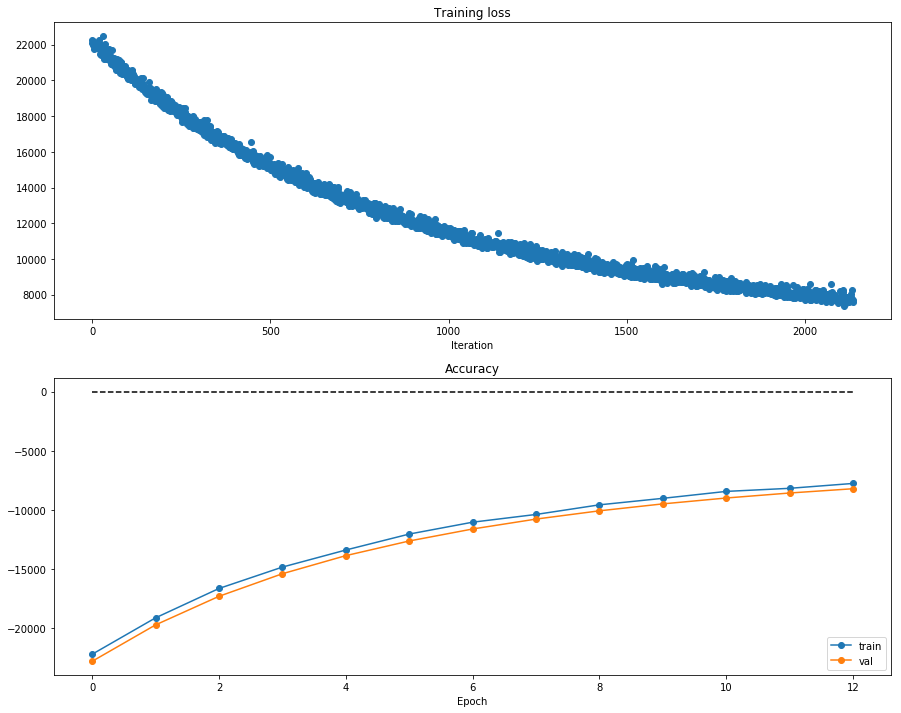

In [46]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()
print()

# Advanced LSTM network
Next we implement the multi-layer LSTM network with an arbitrary number of hidden layers, and the options of batch normalization and dropout, as the `AdvancedLSTM` class in the file `batchnormlstm/classifiers/lstm.py`.

ref: <br />
https://arxiv.org/pdf/1603.09025.pdf <br />
https://arxiv.org/pdf/1409.2329.pdf

## Initial loss and gradient check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization and see if the initial losses seem reasonable.

In [47]:
N, D, H1, H2, O = 2, 15, 20, 30, 10
T = 4
X = np.random.randn(N, T, D)
Y = np.random.randn(N, O)

for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = AdvancedLSTM([H1, H2], input_dim=D, output_dim=O, 
                       reg=reg, weight_scale=5e-2, dtype=np.float64)

  loss, grads = model.loss(X, Y)
  print('Initial loss: ', loss)

  for name in sorted(grads):
    f = lambda _: model.loss(X, Y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running check with reg =  0
Initial loss:  0.6364185128745645
U1 relative error: 6.23e-04
U2 relative error: 1.06e-03
W1 relative error: 1.24e-04
W2 relative error: 6.81e-04
W3 relative error: 6.66e-05
b1 relative error: 2.69e-05
b2 relative error: 1.44e-05
b3 relative error: 4.11e-11
Running check with reg =  3.14
Initial loss:  36.14152720955063
U1 relative error: 6.91e-07
U2 relative error: 8.19e-07
W1 relative error: 7.27e-07
W2 relative error: 3.58e-07
W3 relative error: 2.79e-08
b1 relative error: 6.86e-05
b2 relative error: 1.16e-03
b3 relative error: 2.35e-09


As another sanity check, train on a small dataset of 50 instances. We use three layers of LSTM and tweak the learning rate and initialization scale.

(Iteration 1 / 40) loss: 25834.386138
(Epoch 0 / 20) train_acc: -24585.993359; val_acc: -22754.584035
(Epoch 1 / 20) train_acc: -24553.678901; val_acc: -22722.841330
(Epoch 2 / 20) train_acc: -24489.199432; val_acc: -22659.478862
(Epoch 3 / 20) train_acc: -24424.312421; val_acc: -22595.890431
(Epoch 4 / 20) train_acc: -24359.229251; val_acc: -22532.153400
(Epoch 5 / 20) train_acc: -24292.794632; val_acc: -22467.386107
(Iteration 11 / 40) loss: 23365.510047
(Epoch 6 / 20) train_acc: -24226.185597; val_acc: -22401.898157
(Epoch 7 / 20) train_acc: -24154.486765; val_acc: -22331.632446
(Epoch 8 / 20) train_acc: -24069.942663; val_acc: -22249.184240
(Epoch 9 / 20) train_acc: -23956.483160; val_acc: -22138.375839
(Epoch 10 / 20) train_acc: -23767.291472; val_acc: -21953.807456
(Iteration 21 / 40) loss: 21446.622670
(Epoch 11 / 20) train_acc: -23340.993891; val_acc: -21535.989780
(Epoch 12 / 20) train_acc: -22434.520582; val_acc: -20649.555723
(Epoch 13 / 20) train_acc: -21410.202070; val_acc

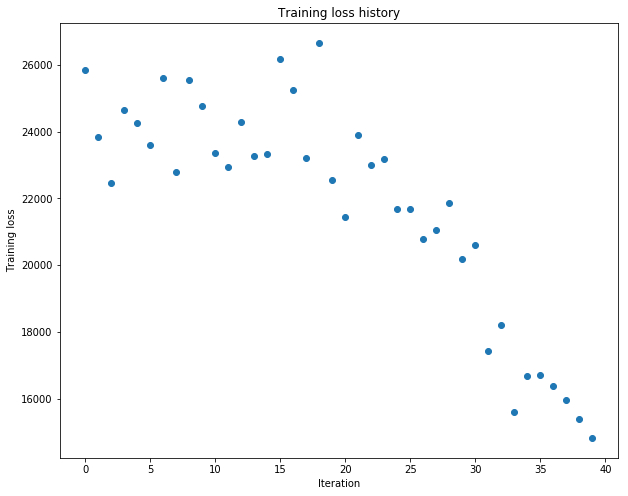

In [48]:
num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 1e-2
learning_rate = 1e-2
model = AdvancedLSTM([20, 10, 20], input_dim=28,
              weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train(regress=True)

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

# Update rules
So far we have used vanilla stochastic gradient descent (SGD) as our update rule. More sophisticated update rules can make it easier to train deep networks. We implement a few of the most commonly used update rules and compare them to vanilla SGD.

# SGD+Momentum
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochstic gradient descent.

In the file `batchnormlstm/optim.py` we implement the SGD+momentum update rule in the function `sgd_momentum`, then run the following to check the implementation. We should see errors less than 1e-8.

In [49]:
from batchnormlstm.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

print('next_w error: ', rel_error(next_w, expected_next_w))
print('velocity error: ', rel_error(expected_velocity, config['velocity']))

next_w error:  8.882347033505819e-09
velocity error:  4.269287743278663e-09


# RMSProp and Adam
RMSProp [1] and Adam [2] are update rules that set per-parameter learning rates by using a running average of the second moments of gradients.

In the file `batchnormlstm/optim.py`, implement the RMSProp update rule in the `rmsprop` function and implement the Adam update rule in the `adam` function, and check the implementations using the tests below.

[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [50]:
# Test RMSProp implementation; we should see errors less than 1e-7
from batchnormlstm.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  9.524687511038133e-08
cache error:  2.6477955807156126e-09


In [51]:
# Test Adam implementation; we should see errors around 1e-7 or less
from batchnormlstm.optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

next_w error:  1.1395691798535431e-07
v error:  4.208314038113071e-09
m error:  4.214963193114416e-09


# Final model
By combining the features and modifying the rules, we can come up with a model that best fits the data. An example is shown below.

In [52]:
adv_model = None
################################################################################
# Train a AdvancedLSTM with modified features and rules. Store the model in    #
# adv_model variable.                                                          #
################################################################################
hidden_dims = [20, 15, 20]
adv_model = AdvancedLSTM(hidden_dims, input_dim=28, 
                         weight_scale=1e-2, dropout=0.95, use_batchnorm=True, reg=3e-5)

solver = Solver(adv_model, data,
                num_epochs=30, batch_size=100,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-2,
                },
                verbose=True, print_every=100, 
                lr_decay = 0.9)

solver.train(regress=True)
################################################################################
#                                                                              #
################################################################################

(Iteration 1 / 5340) loss: 22429.565881
(Epoch 0 / 30) train_acc: -22142.952517; val_acc: -22784.897269
(Iteration 101 / 5340) loss: 20349.013528
(Epoch 1 / 30) train_acc: -18865.138875; val_acc: -19299.204119
(Iteration 201 / 5340) loss: 18602.975270
(Iteration 301 / 5340) loss: 17323.709701
(Epoch 2 / 30) train_acc: -16796.062704; val_acc: -17131.768075
(Iteration 401 / 5340) loss: 16288.072421
(Iteration 501 / 5340) loss: 15502.713236
(Epoch 3 / 30) train_acc: -15196.966181; val_acc: -15526.532841
(Iteration 601 / 5340) loss: 14649.562715
(Iteration 701 / 5340) loss: 14009.695086
(Epoch 4 / 30) train_acc: -14044.081025; val_acc: -14265.049174
(Iteration 801 / 5340) loss: 13185.206727
(Epoch 5 / 30) train_acc: -13031.742671; val_acc: -13231.504870
(Iteration 901 / 5340) loss: 13008.184389
(Iteration 1001 / 5340) loss: 12358.698903
(Epoch 6 / 30) train_acc: -12082.949525; val_acc: -12363.994974
(Iteration 1101 / 5340) loss: 11953.610956
(Iteration 1201 / 5340) loss: 11570.680937
(Epoc

# Test the final model
Run the model on the validation and test sets.

In [54]:
print('Test set accuracy: ')
solver.check_accuracy(data['X_test'], data['y_test'], regress=True)

Test set accuracy: 


-6441.067650268412